Kaggle competition: https://www.kaggle.com/c/digit-recognizer/

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


We need to import Torch's libraries

In [2]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
#import wandb
#from kaggle_secrets import UserSecretsClient
#user_secrets = UserSecretsClient()
#secret_value_0 = user_secrets.get_secret("a")
#wandb.login(key=secret_value_0)
#wandb.init(project='MNIST_MLP', save_code=True)

## Data preparation

A custom dataset which uses the CSV from Kaggle, avoid downloading the dataset from internet

In [3]:
class MyMNISTDataset(Dataset):
    
    def __init__(self, file_path, transform = transforms.Compose([transforms.ToPILImage()]), test_data=False, use_gpu=torch.cuda.is_available()):
        # read the data
        df = pd.read_csv(file_path)
        # for test data we don't have any target
        # MNIST images are 28 by 28, grey colors
        if test_data:
            self.X = df.values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = None
        else:
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = torch.from_numpy(df.iloc[:,0].values)
        self.transform = transform
        self.use_gpu = use_gpu
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        data = self.transform(self.X[idx])
        if self.y is not None:
            target = self.y[idx]
            if self.use_gpu:
                data = data.cuda()
                target = target.cuda()
            return data, target
        else:
            if self.use_gpu:
                data = data.cuda()
            return data

In [4]:
transformations=transforms.Compose([transforms.ToPILImage(), 
                                    transforms.ToTensor(), 
                                    transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_dataset = MyMNISTDataset('/kaggle/input/digit-recognizer/train.csv', transform=transformations, test_data=False)
test_dataset = MyMNISTDataset('/kaggle/input/digit-recognizer/test.csv', transform=transformations, test_data=True)

# create data loader for train, validation and test set
batch_size = 20

num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
    sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

Let us visualize the dataset and check if the loaders are working as they should.

## MLP

### Define model architecture
You need to reach at least 70% accuracy on the test set

In [5]:
class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
        # we will use the following net: 784 -> 512 -> 10
        self.fc1 = nn.Linear(28*28,512)
        self.fc2 = nn.Linear(512,10)
        self.dropout = nn.Dropout(0.2) #dropout to avoid overfitting
        
    def forward(self, x):
        x = x.view(-1, 28 * 28) # flatten image input
        #ReLU + dropout for each layer
        x = F.relu(self.fc1(x))  
        x = self.dropout(x)
    
        #output
        x = self.fc2(x)
        return x

### Init the model and put it on GPU/TPU

In [6]:
#let use the model on the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
model = Net().to(device)

print(model)

lr = 0.01

#We will use Cross-Entropy as Loss function
criterion = nn.CrossEntropyLoss()

#Stochastic GD as optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Using device: cpu
Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


### Training loop
Log the accuracy and the loss to wandb

In [7]:
# number of epochs to train the model
n_epochs = 20
mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []


# initialize tracker for minimum validation loss
for epoch in range(n_epochs):
    train_losses = []
    valid_losses = []
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        #print((data,target))
        #pass the data and the target on the GPU
        #data=data.to(device).float
        #target=target.to(device)
        #print(data.type)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_losses.append(loss.item())
        
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in valid_loader:
            #pass the data and the target on the GPU
            #data=data.to(device).float
            #target=target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # update running validation loss 
            valid_losses.append(loss.item())
            
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

    mean_train_losses.append(np.mean(train_losses))
    mean_valid_losses.append(np.mean(valid_losses))
    
    accuracy = 100*correct/total
    valid_acc_list.append(accuracy)
    print('epoch : {}, train loss : {:.4f}, valid loss : {:.4f}, valid acc : {:.2f}%'\
         .format(epoch+1, np.mean(train_losses), np.mean(valid_losses), accuracy))

epoch : 1, train loss : 0.8104, valid loss : 0.5216, valid acc : 85.06%
epoch : 2, train loss : 0.7006, valid loss : 0.4716, valid acc : 87.31%
epoch : 3, train loss : 0.6893, valid loss : 0.4561, valid acc : 86.26%
epoch : 4, train loss : 0.6774, valid loss : 0.5180, valid acc : 87.48%
epoch : 5, train loss : 0.6762, valid loss : 0.4160, valid acc : 88.68%
epoch : 6, train loss : 0.6877, valid loss : 0.5009, valid acc : 87.31%
epoch : 7, train loss : 0.6658, valid loss : 0.3921, valid acc : 89.62%
epoch : 8, train loss : 0.6672, valid loss : 0.4631, valid acc : 88.14%
epoch : 9, train loss : 0.6633, valid loss : 0.5324, valid acc : 84.86%
epoch : 10, train loss : 0.6582, valid loss : 0.4044, valid acc : 90.23%
epoch : 11, train loss : 0.6535, valid loss : 0.4625, valid acc : 88.39%
epoch : 12, train loss : 0.6491, valid loss : 0.4338, valid acc : 88.20%
epoch : 13, train loss : 0.6451, valid loss : 0.3922, valid acc : 89.96%
epoch : 14, train loss : 0.6971, valid loss : 0.4561, valid 

### Make prediction
And submit to Kaggle for grading

In [8]:
with torch.no_grad():
    model.eval()
    test_pred = torch.LongTensor()
    for i, data in enumerate(test_loader):
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        predicted = predicted.cpu()
        test_pred = torch.cat((test_pred, predicted), dim=0)
    out_df = pd.DataFrame(np.c_[np.arange(1, len(test_dataset)+1)[:,None], test_pred.numpy()], columns=['ImageId', 'Label'])
    out_df.to_csv('submission.csv', index=False)

### Top 10 misclassified images by class probability

In [9]:
import matplotlib.pyplot as plt


unshuffle_train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, shuffle=False)
with torch.no_grad():
    model.eval()
    missclasified = torch.DoubleTensor()
    for batch_idx, (data, target) in enumerate(unshuffle_train_loader):
        output = model(data)
        prob, predicted = torch.max(output.data, 1)
        predicted = predicted.cpu()
        target = target.cpu()
        prob = prob.cpu().double()
        missclassified_prob = torch.where(predicted == target, 0., prob)
        missclasified = torch.cat((missclasified, missclassified_prob), dim=0)
    most_misclassified = torch.argsort(missclasified, descending=True)
    top_ten_misclassified = most_misclassified[:10]

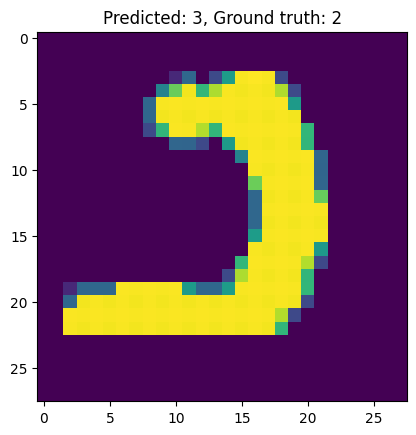

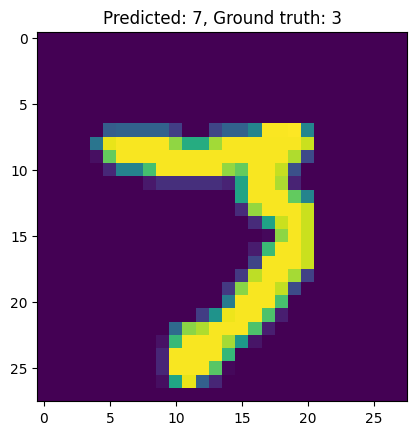

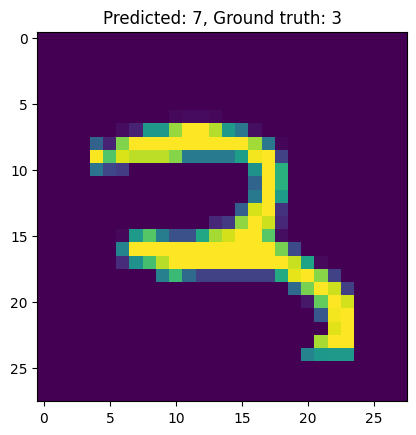

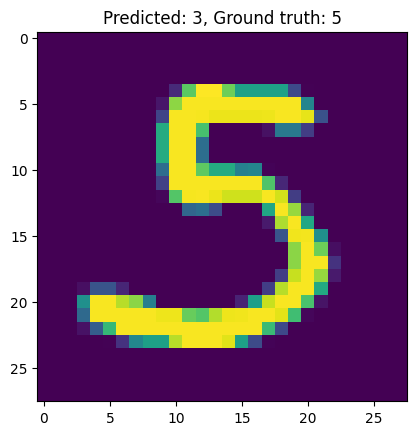

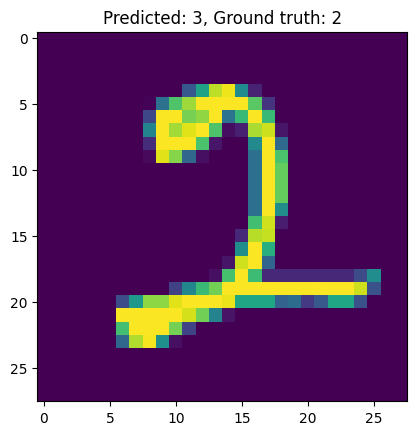

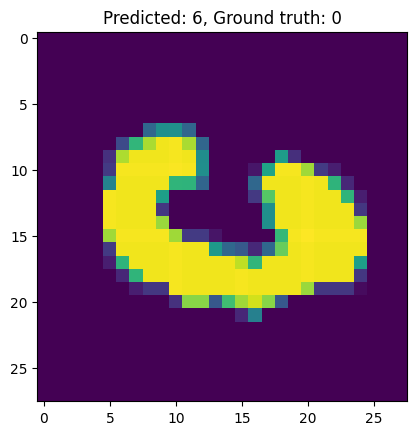

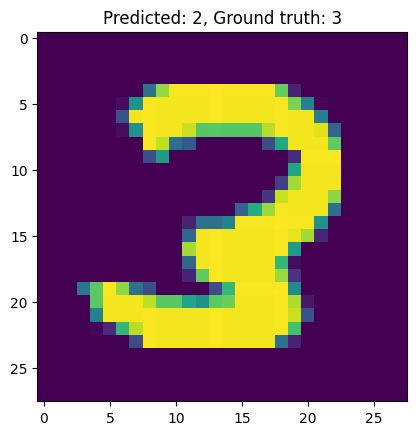

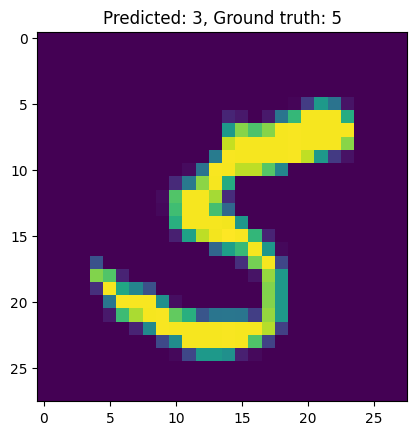

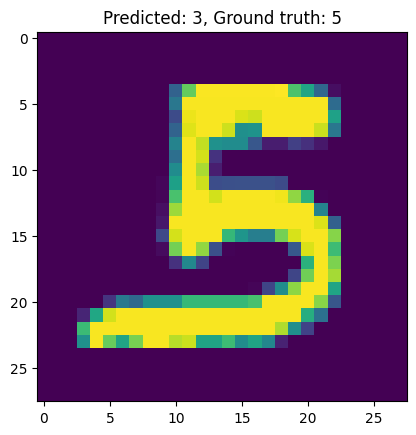

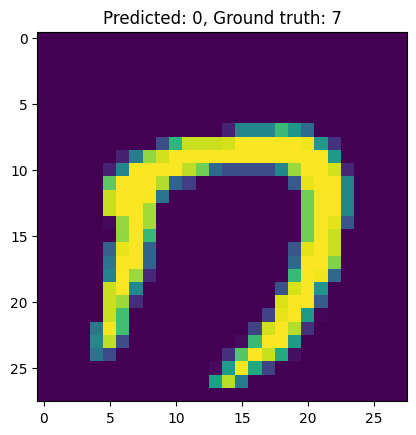

In [10]:
for misclassified in top_ten_misclassified:
    plt.imshow(train_dataset[misclassified][0].cpu().reshape(28,28))
    with torch.no_grad():
        data, target = train_dataset[misclassified]
        data = data.reshape(1, 1, 28,28)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        plt.title(f'Predicted: {predicted.item()}, Ground truth: {target}')
    plt.show()